## Exploring the hyperdictionary

Now, I've run the hyperdictionary with only 80% of the words taken out! This gives us 20k words and 76k elements in the word tree. I've increased the dimensionality of the hypervector to 1milllion. Lets see how it does. How much information can it store? 


In [1]:

import random_idx
import utils
import pickle

from pylab import *

%matplotlib inline

height has been deprecated.

2016-02-24 09:38


In [2]:
h = np.load('data/hyperdictionary_s5_160202.npz')

In [3]:
hyperdictionary = h['hyperdictionary']
letter_vectors = h['letter_vectors']

print hyperdictionary.shape

N = hyperdictionary.shape[0]

(1000000,)


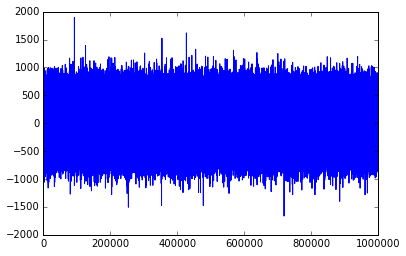

In [4]:
plot(hyperdictionary);

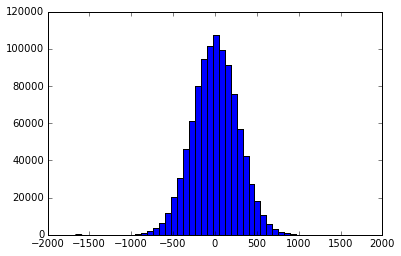

In [5]:
hist(hyperdictionary, 50);

Here is a widget that will display the histogram of the next letter for any string you type. However, you probably cannot run it on the notebook viewer:

In [6]:
def get_next_letters(v, thresh=0.5):
    next_letters = ''
    for idx in np.nonzero(v>thresh)[0]:
        next_letters += random_idx.alphabet[idx]
    return next_letters

'qx'

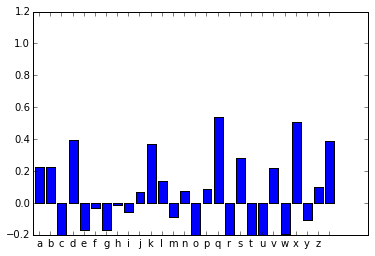

In [7]:
from ipywidgets import widgets
from IPython.display import display
from IPython.html.widgets import *

figure(figsize=(8,5))

def next_letter_hist(instring):
    #instring = sender.value
    subvec = np.ones(N)
    for letter in instring:
        lidx = random_idx.alphabet.find(letter)
        subvec = np.roll(subvec, 1) * letter_vectors[lidx,:]
        
    subvec = np.roll(subvec, 1)
    val = np.dot(letter_vectors/N, subvec*hyperdictionary)
    bar(arange(len(val))+0.15, val)   
    ax=gca()
    ax.set_xticks(arange(len(random_idx.alphabet))+0.5)
    th = ax.set_xticklabels(list(random_idx.alphabet))
    ax.set_ylim([-0.2, 1.2])
    return get_next_letters(val)

#input_text = widgets.Text()
#input_text.on_submit(next_letter_hist)
#display(input_text)

interact(next_letter_hist, instring="")


First, here is just all the letters, basically the dictionary has no 'x' and ' ' starting words:

'abcdefghijklmnopqrstuvwxyz '

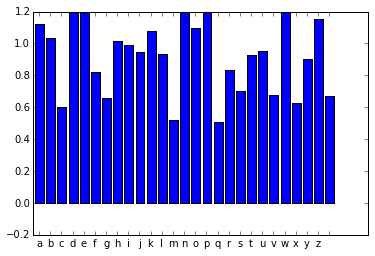

In [10]:
next_letter_hist('')

ok, so now some words that start with space.

'oqw'

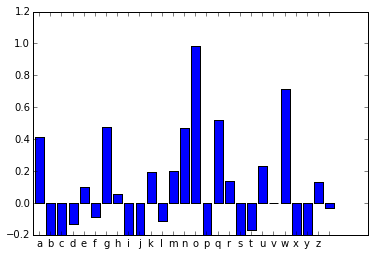

In [11]:
next_letter_hist(' ')

'm'

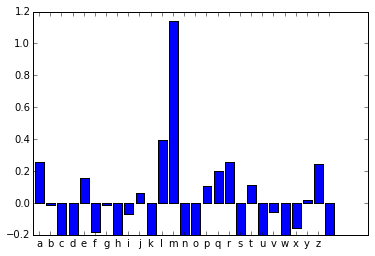

In [12]:
next_letter_hist(' o')

'a'

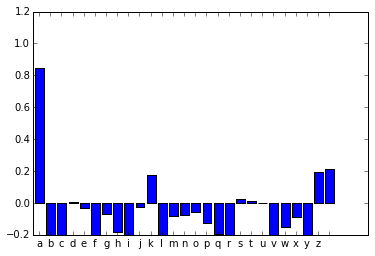

In [13]:
next_letter_hist(' om')

'n'

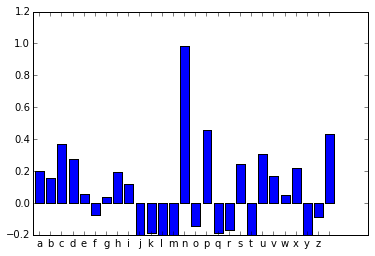

In [15]:
next_letter_hist(' oma')

''

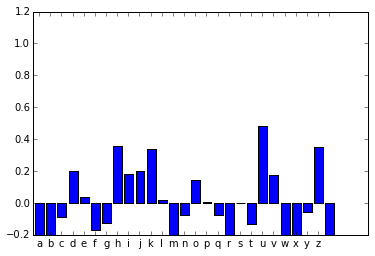

In [17]:
next_letter_hist(' oman')

hmm... weird, maybe I just let a space get in there?

'beiou'

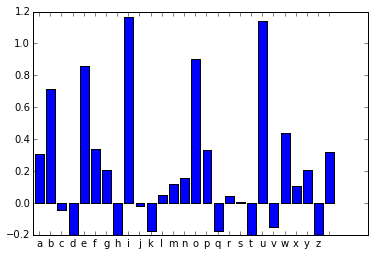

In [18]:
next_letter_hist('str')

strb?

'dlr'

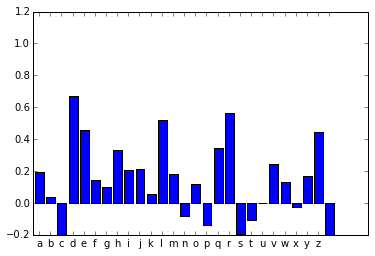

In [19]:
next_letter_hist('strb')

'h'

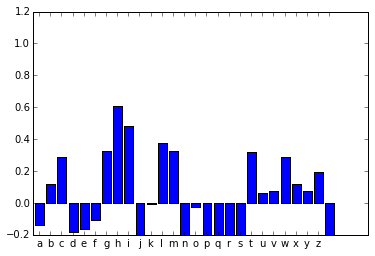

In [20]:
next_letter_hist('strbd')

''

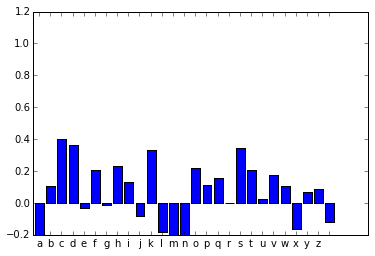

In [21]:
next_letter_hist('strbdh')

't'

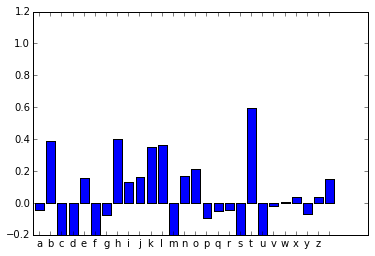

In [22]:
next_letter_hist('strbl')

''

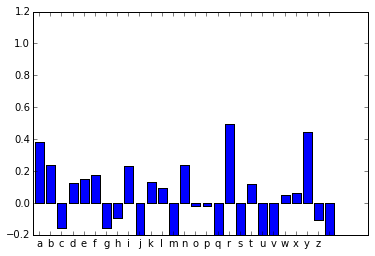

In [23]:
next_letter_hist('strblt')

'anpstwx'

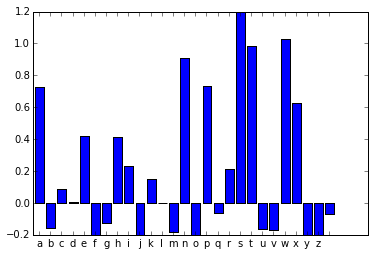

In [24]:
next_letter_hist('stre')

'ms'

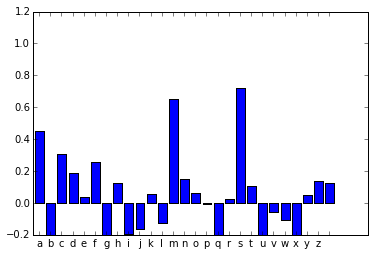

In [26]:
next_letter_hist('stres')

'i'

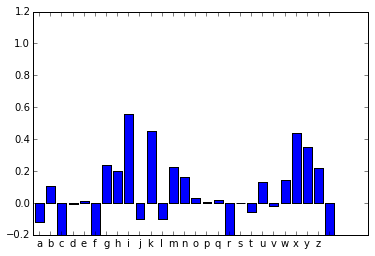

In [27]:
next_letter_hist('stress')

'n'

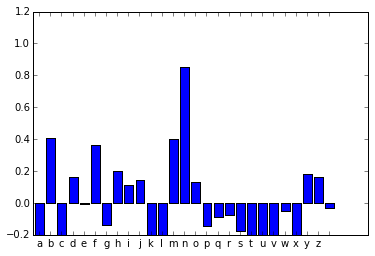

In [28]:
next_letter_hist('stressi')

'g'

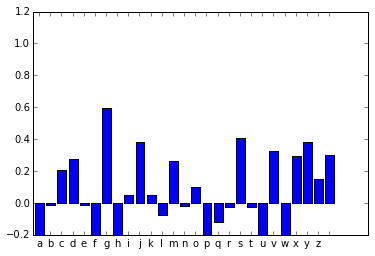

In [29]:
next_letter_hist('stressin')

's'

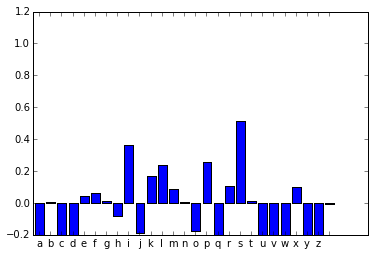

In [30]:
next_letter_hist('stressing')

'amswx'

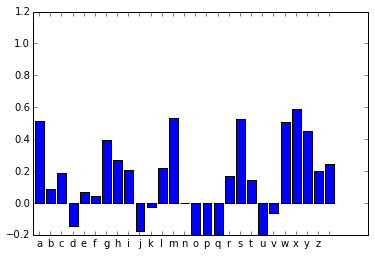

In [31]:
next_letter_hist('stressings')

'x'

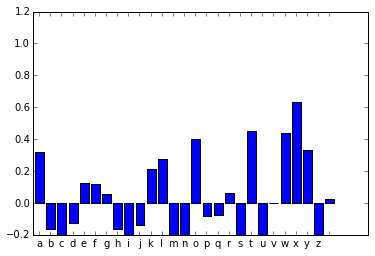

In [32]:
next_letter_hist('stressingsx')

''

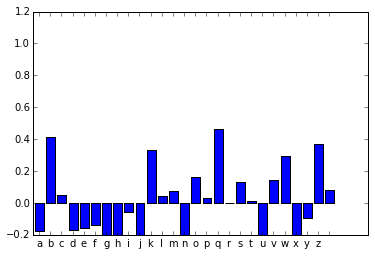

In [33]:
next_letter_hist('stressingsxx')

'e'

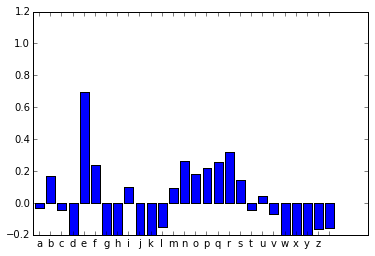

In [34]:
next_letter_hist('stressingss')

'a'

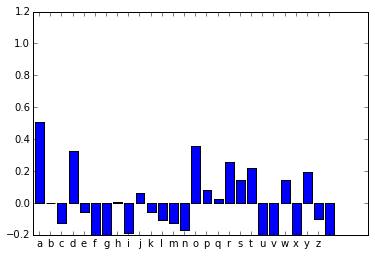

In [35]:
next_letter_hist('stressingsse')

'cj'

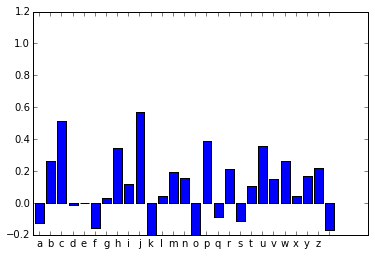

In [36]:
next_letter_hist('stressingssea')

'uw'

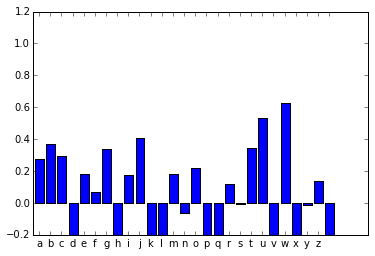

In [38]:
next_letter_hist('stressingsseaj')

So, it appears that there is quite a bit of good information here. However, there is clearly a lot of non-sense as well. With the hyperdictionary we have 1M dimensions and almost 80k categories to store. However, we assign the categories based on essentially random hypervectors. There is a probability that the hypervectors are not orthogonal, based on how many categories the hypervector is trying to store.

# Estimating the capacity of a hyperdictionary/hypervector

There is likely a nice mathematical way to estimate how many categories a hypervector can store, given that each category is just a random projection. Since our hyper vectors are (50%/50%, +1/-1), there is a certain amount and probability of overlap. 

We force the hypervectors to have exactly 50/50 +1/-1, but it may be easier to think of them as independent.

If we have just two N-D hypervectors like this, then the probability of overlap is just flipping a coin for each N:

In [55]:
n, p = 1000, 0.5
trials = 10000
s = np.random.binomial(n, p, trials)

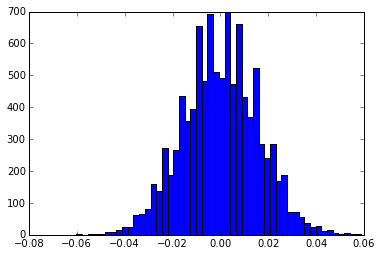

In [56]:
hist((s-mean(s))/n, 50);

So, essentially the closer to the mean, the *more orthogonal* the vectors are. This histogram is related to the probability distribution of the dot product of two random 1000-D ([n]-D) hypervectors. 

In [57]:
# so lets monte-carlo our way to the actual distribution

def random_hypvec_distribution(N_pos=5000, N_neg=5000, trials=10000):
    N = N_pos + N_neg
    
    main_hypvec = np.random.permutation(np.hstack((np.ones(N_pos), -np.ones(N_neg))))

    dot_vals = np.zeros(trials)

    for t in range(trials):
        rhypvec = np.random.permutation(np.hstack((np.ones(N_pos), -np.ones(N_neg))))
    
        dot_vals[t] = np.dot(main_hypvec.T, rhypvec)
        
    return dot_vals


16


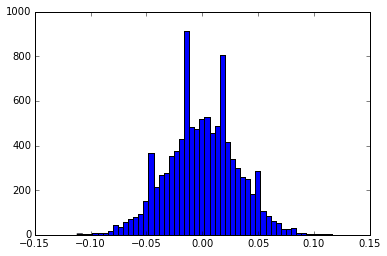

In [60]:
N_pos = 500
N_neg = 500
N = N_pos + N_neg
dot_vals = random_hypvec_distribution(N_pos, N_neg)
hist(dot_vals/N, 50);

print len(np.nonzero(np.abs(dot_vals/N) > 0.1)[0])

So, a bit wider than the pure binomial distribution would suggest, but this is likely because we have exactly (50%/50%, +1/-1). But for any two random 1000-D ([N]-D) hypervectors, we can expect >0.1 dot product around 16/1000=0.16% of the time.

Of course, increasing N tightens the distribution:

0


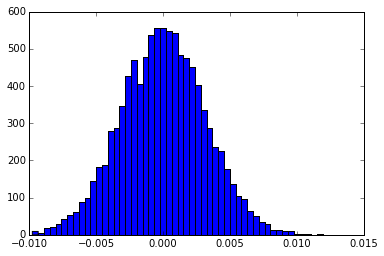

In [61]:
N_pos = 50000
N_neg = 50000
N = N_pos + N_neg
dot_vals = random_hypvec_distribution(N_pos, N_neg)
hist(dot_vals/N, 50);

print len(np.nonzero(np.abs(dot_vals/N) > 0.1)[0])